In [2]:
## Import Useful Libraries
import numpy as np
import random as r
import matplotlib.pyplot as plt 
from  matplotlib.animation import FuncAnimation
import gzip
import math as m
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [3]:
## Lattice class
class Sand_Lattice:
    
    def __init__(self, N, k):
        self.N = N
        self.grid = np.zeros((N, N))
        self.k = k
        self.avalanche_size = 0
        self.avalanche_sizes = []
        self.steps = 0
        self.count = 0
        self.count_history = []
        self.biggest_avalanche = 0
        self.pre_avalanche = np.zeros((N, N))
        self.initiating_move = (0, 0)
        self.to_check = []
        return
        
    def drop(self, num=1):
        points = np.random.randint(self.N, size=[num, 2])
        for i in range(num):
            pt = (points[i][0], points[i][1])
            saved_copy = np.copy(self.grid)
            self.grid[pt] += 1
            self.count += 1
            self.avalanche_size = 0
            self.to_check.append(pt)
            self.check_sizes()
            self.avalanche_sizes.append(self.avalanche_size)
            self.count_history.append(self.count)
            if self.avalanche_size > self.biggest_avalanche:
                self.biggest_avalanche = self.avalanche_size
                self.pre_avalanche = saved_copy
                self.initiating_move = pt
        self.steps += num
        return
                
    def check_sizes(self):
        if len(self.to_check) == 0:
            return
        idx = r.randint(0, len(self.to_check)-1)
        pt = self.to_check[idx]
        self.to_check.remove(pt)
        if self.grid[pt] > self.k:
            self.avalanche_size += 1
            self.grid[pt] += -4
            self.count += -4
            self.fall(pt)
            if self.grid[pt] > self.k:
                self.to_check.append(pt)
        self.check_sizes()
            
    def fall(self, pt):
        if pt[1] != 0:
            left = (pt[0], pt[1]-1)
            self.grid[left] += 1
            self.count += 1
            if self.grid[left] > self.k:
                self.to_check.append(left)
        if pt[1] != self.N-1:
            right = (pt[0], pt[1]+1)
            self.grid[right] += 1
            self.count += 1
            if self.grid[right] > self.k:
                self.to_check.append(right)
        if pt[0] != 0:
            up = (pt[0]-1, pt[1])
            self.grid[up] += 1
            self.count += 1
            if self.grid[up] > self.k:
                self.to_check.append(up)
        if pt[0] != self.N-1:
            down = (pt[0]+1, pt[1])
            self.grid[down] += 1
            self.count += 1
            if self.grid[down] > self.k:
                self.to_check.append(down)
        return
    
    def show(self):
        fig, ax = plt.subplots()
        plot = ax.matshow(self.grid, cmap="YlOrBr_r", vmin=0, vmax=7, animated=True)
        plt.colorbar(plot)
        plt.title(f"Sand Table at {self.steps} Steps")
    
    def current(self):
        return self.grid
    
    def get_avalanches(self, avg=True, window=100):
        if avg:
            return self.rolling_avg(self.avalanche_sizes, window)
        return self.avalanche_sizes
    
    def get_count(self, avg=False, window=100):
        if avg:
            return self.rolling_avg(self.count_history, window)
        return self.count_history
    
    def rolling_avg(self, arr, window):
        to_return = []
        for i in range(len(arr)):
            lower = int(i-window/2)
            upper = int(i+window/2)
            if lower < 0: lower = 0
            if upper >= len(arr): upper = len(arr)-1
            to_return.append(sum(arr[lower:upper])/(upper-lower))          
        return to_return
    
    def return_largest_avalanche(self):
        return self.pre_avalanche, self.initiating_move, self.biggest_avalanche

In [4]:
def get_data(drops=100):
    tab = Sand_Lattice(24, 4)
    data = np.empty(drops+1, dtype=object)
    data[0] = np.copy(tab.current())
    for i in range(drops):
        tab.drop()
        data[i+1] = np.copy(tab.current())
    return data

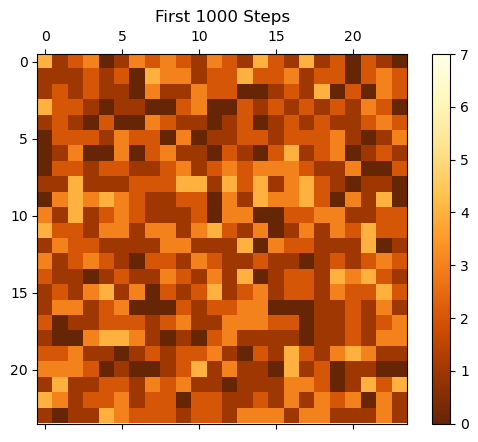

In [4]:
n_frames = 1000
data = get_data(n_frames-1)

fig, ax = plt.subplots()
plot = ax.matshow(data[0], cmap="YlOrBr_r", vmin=0, vmax=7, animated=True)
plt.colorbar(plot)
plt.title(f"First {n_frames} Steps")

def update(i):
    plot.set_array(data[i])
    return [plot]

anim = FuncAnimation(fig, update, frames=n_frames, interval = 15, repeat=True, cache_frame_data=True)
anim.save("animation1.gif")
plt.show()

In [23]:
tab = Sand_Lattice(24, 4)

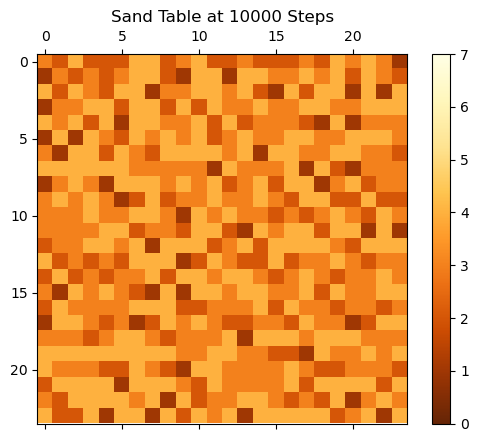

In [24]:
tab.drop(10000)
tab.show()

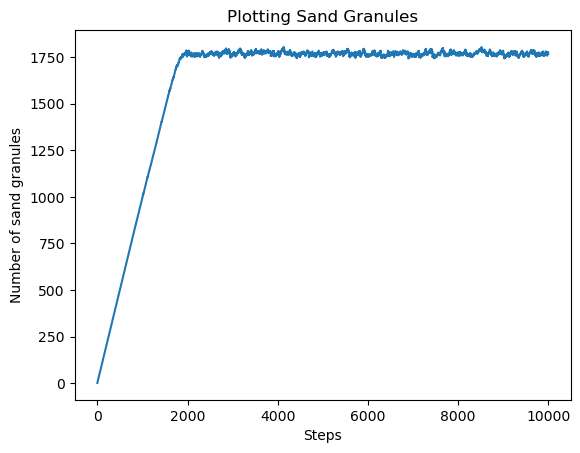

In [25]:
count = tab.get_count()
plt.plot(count)
plt.title("Plotting Sand Granules")
plt.xlabel("Steps")
plt.ylabel("Number of sand granules")
plt.show()

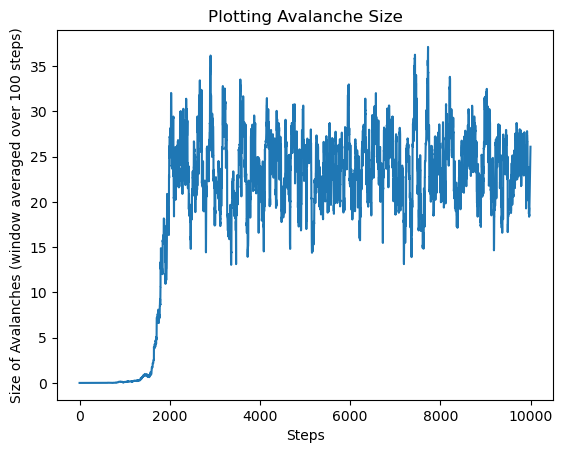

In [26]:
avalanches = tab.get_avalanches()
plt.plot(avalanches)
plt.title("Plotting Avalanche Size")
plt.xlabel("Steps")
plt.ylabel("Size of Avalanches (window averaged over 100 steps)")
plt.show()

In [5]:
avalanches = tab.get_avalanches(avg=False)
values_dict = {}
for i in range(len(avalanches)):
    if int(avalanches[i]) not in values_dict:
        values_dict[int(avalanches[i])] = 0
    values_dict[int(avalanches[i])] += 1
x = []
y = []
for v in values_dict:
    if v == 0:
        continue
    x.append(v)
    y.append(values_dict[v])
for i in range(len(x)):
    x[i] = m.log2(x[i])
    y[i] = m.log2(y[i])
b = []

cutoff= 25
x = np.array(x)
y = np.array(y)
a, b = np.polyfit(x[:cutoff], y[:cutoff], 1)
    
plt.scatter(x, y)
plt.plot(x, a*x+b, color='r', linewidth=2)
print(f"Slope: {a}")

plt.title("Observing Frequency of Avalanche Sizes")
plt.xlabel("Log2(Size of Avalanche)")
plt.ylabel("Log2(Number of Occurrences)")
plt.show()

NameError: name 'tab' is not defined

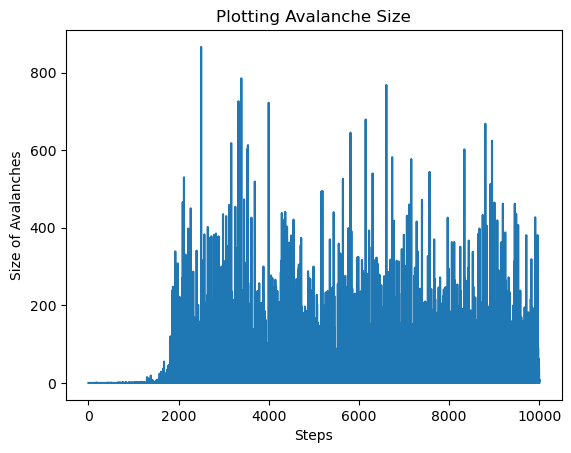

In [10]:
avalanches_unav = tab.get_avalanches(False)
plt.plot(avalanches_unav)
plt.title("Plotting Avalanche Size")
plt.xlabel("Steps")
plt.ylabel("Size of Avalanches")
plt.show()

In [6]:
class avalanche_data():
    def __init__(self, grid, move, k=4):
        self.N = grid.shape[0]
        self.original_grid = grid
        self.grid = grid
        self.k = k
        self.frames = []
        self.move = move
        self.to_check = []
        self.participation_grid = np.zeros(grid.shape)
        self.participation_frames = []
                
    def check_sizes(self):
        if len(self.to_check) == 0:
            return
        idx = r.randint(0, len(self.to_check)-1)
        pt = self.to_check[idx]
        self.to_check.remove(pt)
        if self.grid[pt] > self.k:
            self.grid[pt] += -4
            self.participation_grid[pt] += 1
            self.fall(pt)
            if self.grid[pt] > self.k:
                self.to_check.append(pt)
        self.participation_frames.append(np.copy(self.participation_grid))
        self.frames.append(np.copy(self.grid))
        self.check_sizes()
            
    def fall(self, pt):
        if pt[1] != 0:
            left = (pt[0], pt[1]-1)
            self.grid[left] += 1
            if self.grid[left] > self.k:
                self.to_check.append(left)
        if pt[1] != self.N-1:
            right = (pt[0], pt[1]+1)
            self.grid[right] += 1
            if self.grid[right] > self.k:
                self.to_check.append(right)
        if pt[0] != 0:
            up = (pt[0]-1, pt[1])
            self.grid[up] += 1
            if self.grid[up] > self.k:
                self.to_check.append(up)
        if pt[0] != self.N-1:
            down = (pt[0]+1, pt[1])
            self.grid[down] += 1
            if self.grid[down] > self.k:
                self.to_check.append(down)
        return
    
    def get_avalanche(self):
        self.grid = np.copy(self.original_grid)
        self.participation_grid = np.zeros(self.grid.shape)
        self.participation_frames = [np.copy(self.participation_grid)]
        self.frames = [np.copy(self.grid)]
        pt = self.move
        self.grid[pt] += 1
        self.frames.append(np.copy(self.grid))
        self.participation_frames.append(np.copy(self.participation_grid))
        self.to_check.append(pt)
        self.check_sizes()
        return self.frames, self.participation_grid, self.participation_frames
        

In [165]:
av_table = Sand_Lattice(24, 4)
av_table.drop(5000)
av_grid, move, size = av_table.return_largest_avalanche()
print(size)
data_generator = avalanche_data(av_grid, move)
frames, participation, part_frames = data_generator.get_avalanche()

861


955 955


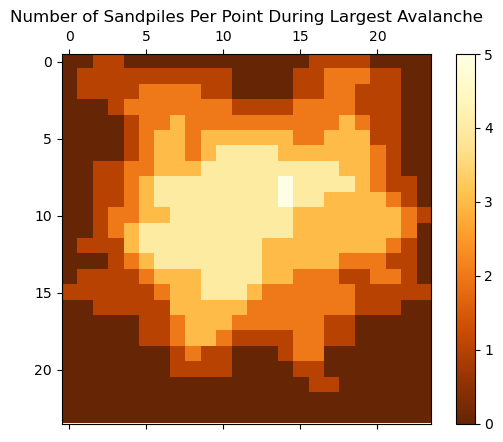

In [166]:
print(len(frames), len(part_frames))
fig, ax = plt.subplots()
plot = ax.matshow(participation, cmap="YlOrBr_r")
plt.colorbar(plot)
plt.title(f"Number of Sandpiles Per Point During Largest Avalanche")
plt.show()

955


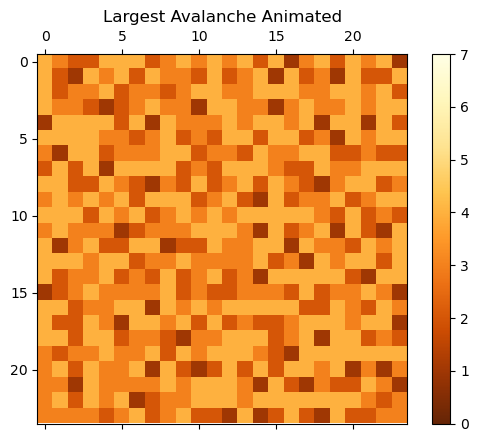

In [167]:
n_frames = len(frames)
print(n_frames)
data = frames

fig, ax = plt.subplots()
plot = ax.matshow(data[0], cmap="YlOrBr_r", vmin=0, vmax=7, animated=True)
plt.colorbar(plot)
plt.title(f"Largest Avalanche Animated")

def update(i):
    plot.set_array(data[i])
    return [plot]

anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=True)
anim.save("avalanche3.gif")
plt.show()

955


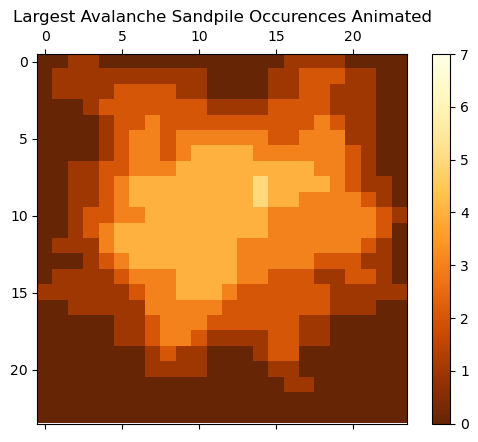

In [168]:
n_frames = len(part_frames)
print(n_frames)
data = part_frames

fig, ax = plt.subplots()
plot = ax.matshow(data[0], cmap="YlOrBr_r", vmin=0, vmax=7, animated=True)
plt.colorbar(plot)
plt.title(f"Largest Avalanche Sandpile Occurences Animated")

def update(i):
    plot.set_array(data[i])
    return [plot]

anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=True)
anim.save("participation1.gif")
plt.show()

955


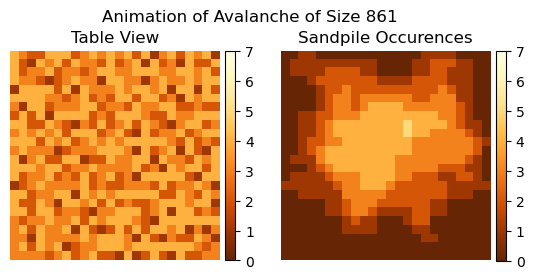

In [214]:
n_frames = len(frames)
print(n_frames)
data = [frames, part_frames]
fig, ax = plt.subplots(1, 2)
plot1 = ax[0].matshow(data[0][0], cmap="YlOrBr_r", vmin=0, vmax=7, animated=True)
plot2 = ax[1].matshow(data[1][0], cmap="YlOrBr_r", vmin=0, vmax=7, animated=True)
ax[0].set_title("Table View", y=1)
ax[1].set_title("Sandpile Occurences", y=1)
ax[0].axis('off')
ax[1].axis('off')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plot2, cax=cax, orientation='vertical')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plot1, cax=cax, orientation='vertical')
plt.suptitle(f"Animation of Avalanche of Size {size}", y=0.8)

def update(i):
    plot1.set_array(data[0][i])
    plot2.set_array(data[1][i])
    return [plot1, plot2]

anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=True)
anim.save("combined_avalanche_1.gif")
plt.show()

In [9]:
tab_big = Sand_Lattice(100, 6)